In [1]:
import os, sys
sys.path.insert(1, '../')

import numpy as np
import scipy as sc
import pandas as pd

from importlib import reload
import utils

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns

## plot comparison of confidence interval widths

In [2]:
df = pd.read_csv('iid-clt-results-011722.csv', index_col=0)
df

,q,n,width,covered,estimator,lower,upper
0,0.25,2000,0.210000,1,prediction-powered,2.864698,3.074698
1,0.25,2000,0.211692,1,classical,2.772702,2.984394
2,0.25,2000,0.200000,1,prediction-powered,2.821820,3.021820
3,0.25,2000,0.208788,1,classical,2.819099,3.027887
4,0.25,2000,0.200000,1,prediction-powered,2.886392,3.086392
...,...,...,...,...,...,...,...
59995,0.75,49,5.476777,1,classical,6.037432,11.514209
59996,0.75,49,3.530000,1,prediction-powered,7.139431,10.669431
59997,0.75,49,4.606437,1,classical,6.740266,11.346702
59998,0.75,49,3.580000,1,prediction-powered,9.124217,12.704217


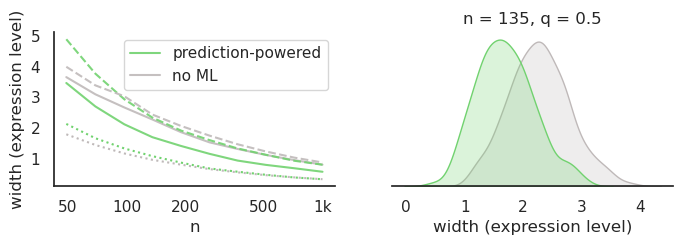

In [5]:
save = True
n_to_plot = 135
c_cl, c_pp = "#BFB9B9", "#71D26F"
ns = np.logspace(np.log10(50), np.log10(1000), num=10, base=10).astype(int)
ns_xticks = [50, 100, 200, 500, 1000]
ns_xticklabels = [50, 100, 200, 500, '1k']
plot_df = df.loc[(df.q == 0.5) & (df.n == n_to_plot)]


fig, axs = plt.subplots(1, 2, figsize=(8, 2))

for q, ls in zip([0.25, 0.5, 0.75], [':', '-', '--']):
    dfqn = df.loc[df.q == q]
    wcl_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'classical')].width.mean()for n in ns])
    wpp_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'prediction-powered')].width.mean()for n in ns])
    axs[0].plot(
        ns, wpp_n,
        label='prediction-powered' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_pp)
    axs[0].plot(
        ns, wcl_n,
        label='no ML' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_cl)
    
axs[0].set_xscale('log')
axs[0].set_xticks(ns_xticks)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels(ns_xticklabels)
axs[0].set_xlabel('n');
axs[0].set_ylabel('width (expression level)')
axs[0].legend();
sns.despine(ax=axs[0],top=True,right=True)

my_palette = sns.color_palette([c_pp, c_cl], 2)
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(
    plot_df, x="width", hue="estimator", hue_order=["prediction-powered", "classical"],
    fill=True, ax=axs[1])
kde.get_legend().remove()
sns.despine(ax=axs[1],top=True,right=True,left=True)
axs[1].set_xlabel("width (expression level)")
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title('n = {}, q = 0.5'.format(n_to_plot));
if save:
    plt.savefig('figures/widths.png', dpi=300, bbox_inches='tight')
plt.show()

## plot one example set of intervals

In [11]:
q = 0.5
n = 75
tmp = df.loc[(df.q == q) & (df.n == n)]
cl_df = tmp[1::2]
pp_df = tmp[0::2]
idx = np.where(
    (cl_df.width.to_numpy() > 6 * pp_df.width.to_numpy())
    & (pp_df.covered.to_numpy() == 1)
    & (cl_df.covered.to_numpy() == 1)
)[0]
print(idx.size)
for i in idx:
    print(i)
    print(cl_df.iloc[i])
    print(pp_df.iloc[i])
    print()

2
222
q                  0.5
n                   75
width         4.421443
covered              1
estimator    classical
lower         4.121189
upper         8.542632
Name: 36445, dtype: object
q                           0.5
n                            75
width                      0.55
covered                       1
estimator    prediction-powered
lower                  5.368949
upper                  5.918949
Name: 36444, dtype: object

274
q                  0.5
n                   75
width         4.972841
covered              1
estimator    classical
lower         4.118024
upper         9.090865
Name: 36549, dtype: object
q                           0.5
n                            75
width                       0.8
covered                       1
estimator    prediction-powered
lower                  4.862686
upper                  5.662686
Name: 36548, dtype: object



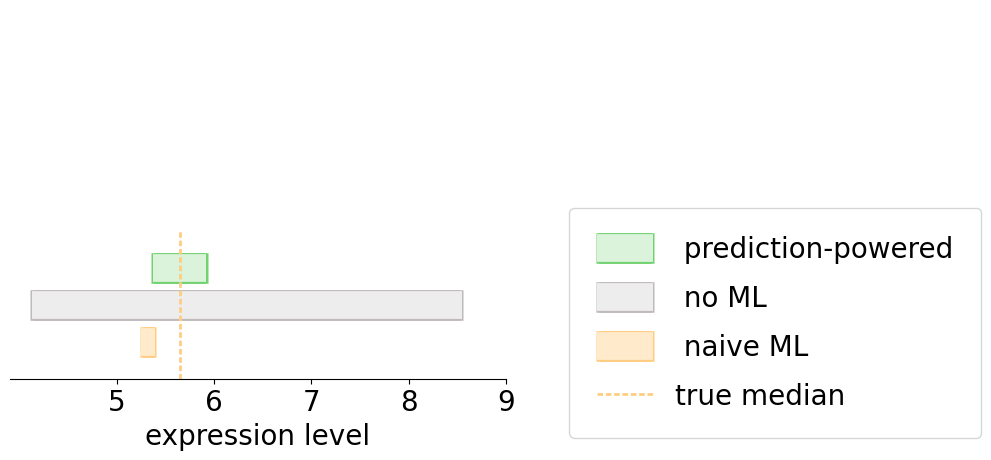

In [14]:
q = 0.5
n = 75
tmp = df.loc[(df.q == q) & (df.n == n)]
cl_df = tmp[1::2]
pp_df = tmp[0::2]
trial = 222
save = False

# true median gene expression
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
theta_star = np.quantile(data_df.measured, 0.5)

# construct naive confidence interval
f_all = data_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))
ci_naive = utils.get_classical_ci(f_all, 0.5, 0.1)

ci_pp = [pp_df.iloc[trial].lower, pp_df.iloc[trial].upper]
ci_cl = [cl_df.iloc[trial].lower, cl_df.iloc[trial].upper]

plt.figure(figsize=(6.4,4.8))
plt.plot(
    ci_pp,[0.3, 0.3],
    linewidth=20, color="#DAF3DA", solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#71D26F"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#71D26F"),
        pe.Normal()
    ],
    label=' prediction-powered'
)
plt.plot(
    ci_cl, [0.2, 0.2],
    linewidth=20, color="#EEEDED",
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#BFB9B9"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#BFB9B9"),
        pe.Normal()
    ],
    label=' no ML'
)
plt.plot(
    ci_naive, [0.1, 0.1],
    linewidth=20, color="#FFEACC", 
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#FFCD82"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#FFCD82"),
        pe.Normal()
    ],
    label=' naive ML'
)
plt.plot(
    [theta_star, theta_star], [0, 0.4], linestyle='--', dashes=(2, 1), linewidth=2,
    label="true median", color="#FFCD82"
)
plt.xlabel("expression level", fontsize=20)
plt.yticks([], labels=[])
plt.xticks([5, 6, 7, 8, 9], fontsize=20)
plt.ylim([0,1])
leg = plt.legend(fontsize=20, borderpad=1, labelspacing = 0.75, bbox_to_anchor=[1.1,0.5])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)

if save:
    plt.savefig('./figures/intervals.pdf', ppi=300, bbox_inches='tight')
plt.show()

## 03.01 Science submission plots

In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [30]:
ns = df.n.unique()
n = ns[1]
q = 0.25

pp_df = df.loc[(df.q == q) & (df.estimator == 'prediction-powered')]
cl_df = df.loc[(df.q == q) & (df.estimator == 'classical')]
wcl_n = np.array([cl_df.loc[cl_df.n == n]['width'].mean()for n in ns])
wpp_n = np.array([pp_df.loc[pp_df.n == n]['width'].mean()for n in ns])

ppn_df = pp_df.loc[pp_df.n == n]
cln_df = cl_df.loc[cl_df.n == n]
lower_endpoints = np.hstack([ppn_df['lower'][:, None], cln_df['lower'][:, None]])
upper_endpoints = np.hstack([ppn_df['upper'][:, None], cln_df['upper'][:, None]])


/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


In [31]:
alpha = 0.1
# true median gene expression
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
theta_star = np.quantile(data_df.measured, q)

# construct naive confidence interval
f_all = data_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))
C_imputed = utils.get_classical_ci(f_all, q, alpha)

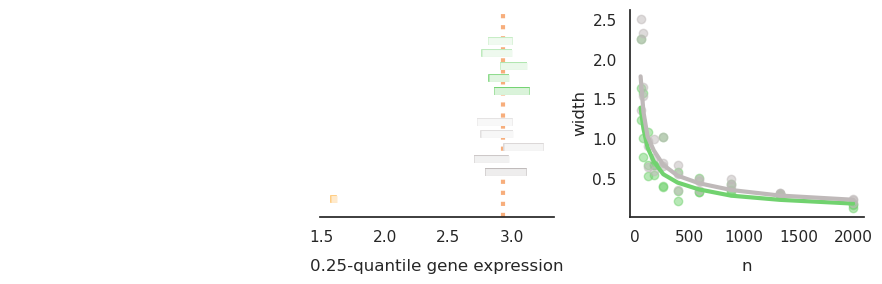

In [39]:
# Make plot
num_intervals = 5
num_trials = len(ppn_df)
save = True
save_fname = './science-sub-q{}.pdf'.format(q)

pp_intervals = []
classical_intervals = []
for i in range(num_intervals):
    trial_idx = np.random.choice(num_trials)
    
    pp_intervals += [
        [lower_endpoints[trial_idx,0], upper_endpoints[trial_idx,0]]
    ]
    
    classical_intervals += [
        [lower_endpoints[trial_idx,1], upper_endpoints[trial_idx,1]]
    ]

xlim = [None, None]
ylim = [0,1.15]
linewidth = 5
linewidth_modifier = 1.1
offset = 0.25
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
sns.set_theme(style="white", font_scale=1, font="DejaVu Sans")
axs[1].axvline(theta_star, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="frequency of spiral galaxies", color="#F7AE7C")

for i in reversed(range(num_intervals)):
    pp_interval = pp_intervals[i]
    classical_interval = classical_intervals[i]
    
    if i == 0:
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7, 0.7], linewidth=linewidth, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#71D26F"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25,0.25], linewidth=linewidth, color="#EEEDED", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#BFB9B9"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
        axs[1].plot([C_imputed[0], C_imputed[1]],[0.1, 0.1], linewidth=linewidth, color="#FFEACC", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#FFCD82"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
    else:
        lighten_factor = 0.8/np.sqrt(i)
        yshift = i*0.07
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7 + yshift, 0.7 + yshift], linewidth=linewidth, color=lighten_color("#DAF3DA", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Normal()], solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25 + yshift,0.25 + yshift], linewidth=linewidth, color=lighten_color("#EEEDED", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Normal()], solid_capstyle="butt")


axs[1].set_xlabel("{}-quantile gene expression".format(q), labelpad=10)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylim(ylim)
axs[1].set_xlim(xlim)

sns.despine(ax=axs[1],top=True,right=True,left=True)

axs[2].plot(ns, wpp_n, label="prediction-powered", color="#71D26F", linewidth=3)
num_scatter = 3
rand_idx_scatter = [np.random.choice(num_trials, size=num_scatter).astype(int) for n in ns]

scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_scatter]) for j in range(ns.shape[0])])
scatter_ys = np.concatenate([pp_df.loc[pp_df.n == n]['width'].to_numpy()[js] for js, n in zip(rand_idx_scatter, ns)])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#71D26F",
    alpha=0.5
)
    
axs[2].plot(ns, wcl_n, label="classical", color="#BFB9B9", linewidth=3)
scatter_ys = np.concatenate([cl_df.loc[cl_df.n == n]['width'].to_numpy()[js] for js, n in zip(rand_idx_scatter, ns)])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#BFB9B9",
    alpha=0.5
)

axs[2].locator_params(axis='y', tight=None, nbins=6)
axs[2].set_ylabel("width")
axs[2].set_xlabel("n",  labelpad=10)
sns.despine(ax=axs[2],top=True, right=True)

sns.despine(ax=axs[0],top=True, right=True, left=True, bottom=True)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

plt.tight_layout()
if save: 
    plt.savefig(save_fname)
plt.show()
